# Create SYNTHETIC dataset

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import skimage.transform
import numpy
import torch 
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from MODULES.namedtuple import BB
from MODULES.cropper_uncropper import Uncropper
from MODULES.non_max_suppression import NonMaxSuppression
from MODULES.utilities_visualization import show_batch, plot_img_and_seg
from MODULES.utilities import save_obj, load_obj
from MODULES.utilities_ml import SpecialDataSet  

# Helper functions

In [14]:
def torch_dilation(img, times: int=1):
    tmp = img.flatten(start_dim=0, end_dim=-4)
    for n in range(times):
        tmp = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)(tmp)
    return tmp.view_as(img)


def make_background_grid_discrete(n_obj):
    width_big  = params["WIDTH_RAW_IMAGE"]
    height_big = params["HEIGHT_RAW_IMAGE"]
    rotated_bg = numpy.zeros((n_obj,1,width_big,height_big))
    
    for i in range(n_obj):
        angle = 15.0 * numpy.random.randint(low=0, high=4, size=1, dtype=int)  # 0,15,30,45
        dx,dy = 10 + 5 * numpy.random.randint(low=0, high=3, size=2, dtype=int)  # 10,15,20
        template = numpy.zeros((2*width_big,2*height_big))
        template[::dx,:]=1
        template[:,::dy]=1
        tmp = skimage.transform.rotate(template, angle, resize=False, center=None, order=1, clip=True, preserve_range=True)
        rotated_bg[i,0] = tmp[width_big//2:width_big//2+width_big,height_big//2:height_big//2+height_big]
    return torch.from_numpy(rotated_bg).float()


def make_background_grid(n_obj=10):
    width_big  = params["WIDTH_RAW_IMAGE"]
    height_big = params["HEIGHT_RAW_IMAGE"]
    rotated_bg = numpy.zeros((n_obj,1,width_big,height_big))
    
    for i in range(n_obj):
        angle = numpy.random.rand(1)*45
        dx,dy = (10+10*numpy.random.rand(2)).astype(int)
        template = numpy.zeros((2*width_big,2*height_big))
        template[::dx,:]=1
        template[:,::dy]=1
        tmp = skimage.transform.rotate(template, angle, resize=False, center=None, order=1, clip=True, preserve_range=True)
        rotated_bg[i,0] = tmp[width_big//2:width_big//2+width_big,height_big//2:height_big//2+height_big]
    return torch.from_numpy(rotated_bg).float()


def make_single_disks(size=28,n_obj=400):
    x_mat = torch.linspace(-1.0, 1.0,steps=size).view(-1,1).expand(size,size).float()
    y_mat = x_mat.clone().permute(1,0)
    r2   = (x_mat**2 + y_mat**2)
    disk = (r2<1.0).float()
    fake_labels = disk.new_zeros(n_obj)
    return disk[None,None,...].expand(n_obj,-1,-1,-1),fake_labels


def make_single_blobs(size=28, n_obj=400):
    N_HARMONICS=3
    
    # Preparation. Create matrcices with cos and sin
    x_mat = torch.linspace(-1.0, 1.0,steps=size).view(-1,1).expand(size,size).float()
    y_mat = x_mat.clone().permute(1,0)
    r2_mat   = (x_mat**2 + y_mat**2)
    r_mat = torch.where(r2_mat>0, r2_mat.sqrt(), torch.zeros_like(r2_mat)).clamp(min=1E-6)
    cos_theta = x_mat/r_mat
    theta_tmp = torch.acos(cos_theta)
    theta = torch.where(y_mat>0, theta_tmp, -theta_tmp)
    # print(torch.max(theta), torch.min(theta))
    n = 1+torch.arange(N_HARMONICS)
    n_theta = n.view(-1,1,1) * theta 
    cos_n_theta = torch.cos(n_theta)
    sin_n_theta = torch.sin(n_theta)
    # print("cos_n_theta.shape",cos_n_theta.shape)
    
    # Compute: r(theta) = 1 + sum_n [ a_n cos(n*theta) + b_n sin(n*theta)]
    a = 1E-1 * torch.randn((n_obj, N_HARMONICS,1,1))
    b = 1E-1 * torch.randn((n_obj, N_HARMONICS,1,1))
    rf = 0.8 + (a*cos_n_theta + b*sin_n_theta).sum(dim=-3)  # this is 

    # compute the blobs
    blobs = (r_mat < rf).float().unsqueeze(-3)
    fake_labels = blobs.new_zeros(n_obj)
    return blobs, fake_labels


def make_single_disks_with_shading(size=28, n_obj=400):
    x_mat = torch.linspace(-1.0, 1.0,steps=size).view(-1,1).expand(size,size).float()
    y_mat = x_mat.clone().permute(1,0)
    r2   = (x_mat**2 + y_mat**2)
    disk = torch.exp(-r2)*(r2<1.0).float()
    fake_labels = disk.new_zeros(n_obj)
    return disk[None,None,...].expand(n_obj,-1,-1,-1),fake_labels


def create_dataset(params, dataset_single_objects, n_for_class=100):
    print(" ")
    print("Creating multi-object dataset")
    
    n_max_objects = params["N_MAX_OBJECTS"]
    width_big  = params["WIDTH_RAW_IMAGE"]
    height_big = params["HEIGHT_RAW_IMAGE"]
    min_size = params["MIN_OBJECT_SIZE"]
    max_size = params["MAX_OBJECT_SIZE"]
    min_n_obj = params["N_MIN_OBJECTS"]
    max_n_obj = params["N_MAX_OBJECTS"]
    
    N_IMG_AT_ONCE = 64
    N_SINGLE_OBJECTS = N_IMG_AT_ONCE * 3 * n_max_objects
    random_sampler = torch.utils.data.RandomSampler(dataset_single_objects,
                                                    replacement=True, 
                                                    num_samples=N_SINGLE_OBJECTS)

    dataloader = torch.utils.data.DataLoader(dataset_single_objects,
                                             batch_size=N_SINGLE_OBJECTS,
                                             sampler=random_sampler)
    
    uncropper = Uncropper()
    nms = NonMaxSuppression()
    
    goal_for_class = torch.ones(1 + max_n_obj) * n_for_class
    goal_for_class[:min_n_obj] = 0
    n_goal = torch.sum(goal_for_class).int().item()
    data_imgs = torch.zeros((n_goal,1,width_big,height_big), dtype=torch.float)
    data_seg = torch.zeros((n_goal,1,width_big,height_big), dtype=torch.uint8)
    data_count = torch.zeros(n_goal, dtype=torch.uint8)
    
    n_current = 0
    while n_current <  n_goal:
        
        # Generate the small objects
        objects, labels = next(iter(dataloader))
        dependent_dim = list(objects.shape[-3:])
        small_objects = objects.view([-1,N_IMG_AT_ONCE]+dependent_dim)
        labels = labels.view(-1,N_IMG_AT_ONCE) + 1
        
        # Generate the random locations and scores
        random = torch.rand([4]+list(small_objects.shape[:2]))
        tp, tx, ty, tsize = torch.split(random, 1, dim=0)         
        fake_score = tp.squeeze(0)
        bw_dimfull = min_size + (max_size-min_size) * tsize.squeeze(0)
        bh_dimfull = bw_dimfull
        bx_dimfull = 0.5*bw_dimfull + (width_big-bw_dimfull)*tx.squeeze(0)
        by_dimfull = 0.5*bw_dimfull + (width_big-bw_dimfull)*ty.squeeze(0)
        bounding_box = BB(bx=bx_dimfull, by=by_dimfull, bw=bw_dimfull, bh=bh_dimfull)
      
        # Uncrop 
        big_objects = uncropper.uncrop(bounding_box, small_objects, width_big, height_big)
        
        # Compute non-Max-Suppression
        nms_output: NMSoutput = nms.compute_mask_and_index(score=fake_score,
                                                           bounding_box=bounding_box,
                                                           overlap_threshold=params["OVERLAP_THRESHOLD"],
                                                           n_objects_max=n_max_objects,
                                                           topk_only=False)
        
        # Select non-overlapping object
        # print("nms_output.index_top_k.shape", nms_output.index_top_k.shape)
        index_select = nms_output.index_top_k[...,None,None,None].expand([n_max_objects]+list(big_objects.shape[-4:])) 
        obj_selected = torch.gather(big_objects, dim=0, index=index_select)  #n_max_objects, batch_size, 1, width_big, height_big
        # print("labels.shape",labels.shape)
        label_selected = torch.gather(labels, dim=0, index=nms_output.index_top_k).to(torch.uint8)
        c_selected_old = torch.gather(nms_output.nms_mask, dim=0, index=nms_output.index_top_k).to(torch.uint8)
        # print("label_selected.shape",label_selected.shape)
        # print("c_selected_old.shape",c_selected_old.shape)
        
        # Drop some object to achieve balanced class
        counter_for_class = torch.bincount(data_count, minlength=1 + max_n_obj)
        c_selected = drop_some_objects(c_selected_old, counter_for_class, goal_for_class)
        
        count = torch.sum(c_selected, dim=0)
        available_for_class = torch.bincount(count, minlength=counter_for_class.shape[0]).int()
        print("counter_for_class ---->",counter_for_class)
        # print("available_for_class -->",available_for_class )

        # Compute foreground, labels, counts
        obj_selected_no_overlap = obj_selected * c_selected[...,None,None,None]
        label_selected_no_overlap = label_selected * c_selected
        obj_mask = (obj_selected_no_overlap > 0.01) * label_selected_no_overlap[...,None,None,None] # size: 6, 64, 1, 80, 80
        
        count_label = torch.sum(c_selected, dim=0).to(torch.uint8)
        seg_mask = torch.max(torch_dilation(obj_mask.float(), times=2), dim=0)[0].to(torch.uint8)
        
        # trick to determine depth (and occlusion)
        a = obj_mask * (torch.arange(obj_mask.shape[0])+1).view(-1,1,1,1,1)
        index = torch.max(a, dim=0, keepdims=True)[1]
        fg = torch.gather(obj_selected_no_overlap, dim=0, index=index).squeeze(0)
        
        # Other way in which I simply sum and clamp
        # fg = torch.sum(obj_selected_no_overlap, dim=-5).clamp_(max=1.0)
         
        # Add to the dataset
        use_this = (count_label > 0)
        dn_max = n_goal-n_current
        dn_available = torch.sum(use_this)
        dn = min(dn_max, dn_available)
        data_imgs[n_current:n_current+dn] = fg[use_this][:dn]
        data_seg[n_current:n_current+dn] = seg_mask[use_this][:dn]
        data_count[n_current:n_current+dn] = count_label[use_this][:dn]
        n_current += dn
    return data_imgs, data_seg, data_count
    

def drop_some_objects(c_selected_old, counter_for_class, goal_for_class):
    """ drop some object by changing the indicator function.
        It start greedely from the most object and remove object 1by1
    """    
    count = torch.sum(c_selected_old, dim=0)
    available_for_class = torch.bincount(count, minlength=counter_for_class.shape[0]).int()
    missing_for_class = (goal_for_class - counter_for_class).clamp(min=0).int()
    drop_for_class = (available_for_class - missing_for_class).clamp(min=0) 
    #print(" ")
    #print(" ")
    #print("counter_for_class ---->",counter_for_class)
    #print("missing_for_class ---->",missing_for_class)
    #print("available_for_class -->",available_for_class,"-->",torch.sum(available_for_class))
    #print("drop_for_class ------->",drop_for_class)
    
    for cl in range(drop_for_class.shape[0]-1,0,-1): # count backward
        n_dropped = 0
        while drop_for_class[cl] > n_dropped:
            # If there is something to do. I will loop over everything and drop stuff
            for i in range(count.shape[0]):
                if count[i]==cl:
                    index = torch.argmax(c_selected_old[:,i].int(), dim=0)
                    c_selected_old[index,i] = 0
                    n_dropped += 1
                    if (n_dropped == drop_for_class[cl]):
                        return drop_some_objects(c_selected_old, counter_for_class, goal_for_class)
                    
    return c_selected_old       

# Single object datasets

In [15]:
write_dir_single_MNIST = "./single_MNIST/"

transform = transforms.ToTensor()
mnist_trainset = torchvision.datasets.MNIST(write_dir_single_MNIST, train=True, download=True, transform=transform)
mnist_testset  = torchvision.datasets.MNIST(write_dir_single_MNIST, train=False, download=True, transform=transform)

tmp_disk_train = make_single_disks(size=28,n_obj=2000)
tmp_disk_test = make_single_disks(size=28,n_obj=2000)
disks_trainset = torch.utils.data.TensorDataset(*tmp_disk_train)
disks_testset = torch.utils.data.TensorDataset(*tmp_disk_test)

tmp_disk_shading_train = make_single_disks_with_shading(size=28,n_obj=2000)
tmp_disk_shading_test = make_single_disks_with_shading(size=28,n_obj=2000)
disks_with_shading_trainset = torch.utils.data.TensorDataset(*tmp_disk_shading_train)
disks_with_shading_testset = torch.utils.data.TensorDataset(*tmp_disk_shading_test)

tmp_blobs_train = make_single_blobs(size=28,n_obj=2000)
tmp_blobs_test = make_single_blobs(size=28,n_obj=2000)
blobs_trainset = torch.utils.data.TensorDataset(*tmp_blobs_train)
blobs_testset = torch.utils.data.TensorDataset(*tmp_blobs_train)



### Visualize the single objects (for example)

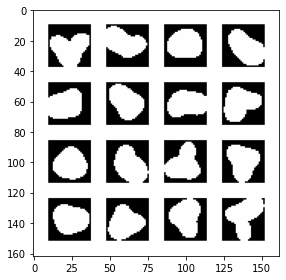

In [16]:
show_batch(tmp_blobs_test[0][:16])

# Multi object datasets

In [23]:
n_for_class_train = 1000
n_for_class_test = 100

#params = {
#    "N_MIN_OBJECTS": 2,
#    "N_MAX_OBJECTS": 6,
#    "MIN_OBJECT_SIZE": 20,
#    "MAX_OBJECT_SIZE": 40,
#    "WIDTH_RAW_IMAGE": 80,
#    "HEIGHT_RAW_IMAGE": 80,
#    "OVERLAP_THRESHOLD" : 0.3
#    }
#multi_mnist_train = create_dataset(params=params, dataset_single_objects=mnist_trainset, n_for_class=10)
#multi_mnist_test = create_dataset(params=params, dataset_single_objects=mnist_testset, n_for_class=10) 
#save_obj(multi_mnist_train, "./multi_mnist_train.pt")
#save_obj(multi_mnist_test, "./multi_mnist_test.pt")

params = {
    "N_MIN_OBJECTS": 2,
    "N_MAX_OBJECTS": 4,
    "MIN_OBJECT_SIZE": 20,
    "MAX_OBJECT_SIZE": 30,
    "WIDTH_RAW_IMAGE": 80,
    "HEIGHT_RAW_IMAGE": 80,
    "OVERLAP_THRESHOLD" : 0.4
    }
multi_disk_shading_train = create_dataset(params=params, dataset_single_objects=disks_with_shading_trainset, n_for_class=n_for_class_train) 
multi_disk_shading_test = create_dataset(params=params, dataset_single_objects=disks_with_shading_testset, n_for_class=n_for_class_test)  
save_obj(multi_disk_shading_train, "./multi_disk_shading_train.pt")
save_obj(multi_disk_shading_test, "./multi_disk_shading_test.pt")

#multi_disk_train = create_dataset(params=params, dataset_single_objects=disks_trainset, n_for_class=n_for_class_train)
#multi_disk_test = create_dataset(params=params, dataset_single_objects=disks_testset, n_for_class=n_for_class_test)  
#save_obj(multi_disk_train, "./multi_disk_train.pt")
#save_obj(multi_disk_test, "./multi_disk_test.pt")

#multi_blobs_train = create_dataset(params=params, dataset_single_objects=blobs_trainset, n_for_class=n_for_class_train) 
#multi_blobs_test = create_dataset(params=params, dataset_single_objects=blobs_testset, n_for_class=n_for_class_test)
#save_obj(multi_blobs_train, "./multi_blobs_train.pt")
#save_obj(multi_blobs_test, "./multi_blobs_test.pt")

 
Creating multi-object dataset
counter_for_class ----> tensor([3000,    0,    0,    0,    0])
counter_for_class ----> tensor([2936,    0,    0,    0,   64])
counter_for_class ----> tensor([2872,    0,    0,    0,  128])
counter_for_class ----> tensor([2808,    0,    0,    0,  192])
counter_for_class ----> tensor([2744,    0,    0,    3,  253])
counter_for_class ----> tensor([2680,    0,    0,    3,  317])
counter_for_class ----> tensor([2616,    0,    0,    3,  381])
counter_for_class ----> tensor([2552,    0,    0,    5,  443])
counter_for_class ----> tensor([2488,    0,    0,    5,  507])
counter_for_class ----> tensor([2424,    0,    0,    5,  571])
counter_for_class ----> tensor([2360,    0,    0,    6,  634])
counter_for_class ----> tensor([2296,    0,    0,    6,  698])
counter_for_class ----> tensor([2232,    0,    0,    7,  761])
counter_for_class ----> tensor([2168,    0,    0,    8,  824])
counter_for_class ----> tensor([2104,    0,    0,    9,  887])
counter_for_class ---->

# Make the no_shade from the shade dataset

In [24]:
save_obj(multi_disk_shading_train, "./FINAL_multi_disk_shading_train.pt")
img, mask, count = multi_disk_shading_train
no_shade_img = (img>0).to(img.dtype)
save_obj((no_shade_img,mask, count), "./FINAL_multi_disk_NO_shading_train.pt")

save_obj(multi_disk_shading_test, "./FINAL_multi_disk_shading_test.pt")
img, mask, count = multi_disk_shading_test
no_shade_img = (img>0).to(img.dtype)
save_obj((no_shade_img,mask, count), "./FINAL_multi_disk_NO_shading_test.pt")

# Visualize the multi objects dataset

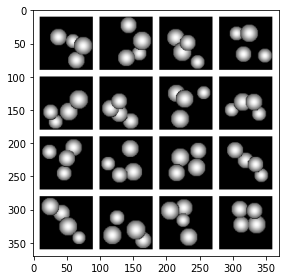

In [25]:
show_batch(img[:16])

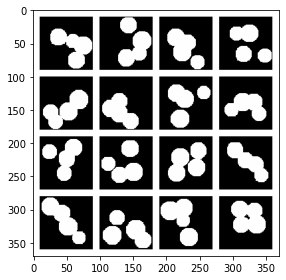

In [26]:
show_batch(no_shade_img[:16])

# Add grid to existing dataset

In [ ]:
#img, seg_mask, count = load_obj("./multi_mnist_train.pt")
#grid = make_background_grid_discrete(img.shape[0])
#img_with_grid = (img+grid).clamp(max=1.0)
#save_obj((img_with_grid, seg_mask, count), "./DISCRETE_GRID_multi_mnist_train.pt")
#
#img, seg_mask, count = load_obj("./multi_mnist_test.pt")
#grid = make_background_grid_discrete(img.shape[0])
#img_with_grid = (img+grid).clamp(max=1.0)
#save_obj((img_with_grid, seg_mask, count), "./DISCRETE_GRID_multi_mnist_test.pt")

In [ ]:
print(data_imgs.shape)
print(data_seg.shape)
print(data_count.shape)

show_batch(data_imgs[:16])